In [17]:
import os
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
try:
    from matplotlib import pyplot as plt
    MATPLOTLIB = True
except:
    MATPLOTLIB = False

import torch    
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [10]:
class CifarDataSet(Dataset):
    def __init__(self, batch_dir_path, train=True):
        super().__init__()
        if not os.path.isdir(batch_dir_path):
            raise FolderDoesNotExist(batch_dir_path)
        all_batch_files = sorted(glob(f"{batch_dir_path}/data_batch_*"))
        if not all_batch_files:
            raise FileNotFoundError(f"No data_batch_n files found in {batch_dir_path}")

        lst_imgs, lst_labels = [], []
        if train:
            # return the 1st n-1 batches for training
            for fi_path in all_batch_files[:-1]:
                i, l = self.unpickle(fi_path)
                lst_imgs.append(i)
                lst_labels.extend(l)
            self.data = np.row_stack(lst_imgs).reshape((-1, 3, 32, 32))
            self.labels = lst_labels
        else:
            # return the nth batch for testing
            for fi_path in all_batch_files[-1:]:
                i, l = self.unpickle(fi_path)
                lst_imgs.append(i)
                lst_labels.extend(l)
            self.data = np.row_stack(lst_imgs).reshape((-1, 3, 32, 32))
            self.labels = lst_labels

    def unpickle(self, f):
        with open(f, "rb") as fo:
            dct = pickle.load(fo, encoding="bytes")
        # normalizing
        return dct.get(b"data") / 255.0, dct.get(b"labels")

    def get_image(self, index, plot=False):
        i = self.data[index]
        l = self.labels[index]
        i = np.transpose(i, axes=(1, 2, 0))
        if plot and MATPLOTLIB:
            plt.imshow(i)
        else:
            return i

    def __getitem__(self, index):
        return (
            self.data[index].astype(np.float32),
            self.labels[index],
        )

    def __len__(self):
        return self.data.shape[0]

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        keep_prob = 0.7
        self.encoder_b1 = nn.Sequential(
                    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
                )
        self.encoder_b2 = nn.Sequential(
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
                )
        self.encoder_b3 = nn.Sequential(
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
                )
        self.encoder_b4 = nn.Sequential(
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True),
                )
        self.encoder_b5 = nn.Sequential(
                    nn.BatchNorm2d(num_features=512),
                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, padding=1),
                )


        self.decoder_b1 = nn.Sequential(
                nn.ConvTranspose2d(1024, 512, 4, padding=1),
                nn.BatchNorm2d(num_features=512),
                )
        self.decoder_b2 = nn.MaxUnpool2d(kernel_size=2, stride=2,)
        self.decoder_b3 = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(512, 256, 3, padding=1),
                nn.BatchNorm2d(num_features=256),
                )
        self.decoder_b4 = nn.MaxUnpool2d(kernel_size=2, stride=2,)
        self.decoder_b5 = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(256, 128, 3, padding=1),
                nn.BatchNorm2d(num_features=128),
                )
        self.decoder_b6 = nn.MaxUnpool2d(kernel_size=2, stride=2,)
        self.decoder_b7 = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, 3, padding=1),
                nn.BatchNorm2d(num_features=64),
                )
        self.decoder_b8 = nn.MaxUnpool2d(kernel_size=2, stride=2,)
        self.decoder_b9 = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(64, 3, 3, padding=1),
                )
        
    def forward(self, x):
        op, i1 = self.encoder_b1(x)
        op, i2 = self.encoder_b2(op)
        op, i3 = self.encoder_b3(op)
        op, i4 = self.encoder_b4(op)
        op = self.encoder_b5(op)

        op = self.decoder_b1(op)
        op = self.decoder_b2(op, i4)
        op = self.decoder_b3(op)
        op = self.decoder_b4(op, i3)
        op = self.decoder_b5(op)
        op = self.decoder_b6(op, i2)
        op = self.decoder_b7(op)
        op = self.decoder_b8(op, i1)
        op = self.decoder_b9(op)
        return op

In [71]:
def train(model, train_loader, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()  # mean square error loss
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-5
    ) 
    outputs = []
    losses = []
    for epoch in range(num_epochs):
        for data in tqdm(train_loader):
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append([epoch,float(loss)])

        print("Epoch:{}, Loss:{:.4f}".format(epoch + 1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs, losses

In [72]:
m = AutoEncoder()

In [73]:
train_ds = CifarDataSet(
            batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", train=True
        )
test_ds = CifarDataSet(
    batch_dir_path="/home/pranjal/pytorch/Datasets/cifar-10-batches-py/", train=False
)

In [74]:
tl = DataLoader(test_ds,batch_size=64)

In [75]:
ops = train(m, tl, 2)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch:1, Loss:0.0805


100%|██████████| 157/157 [05:51<00:00,  2.24s/it]

Epoch:2, Loss:0.0389


In [76]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
all_losses = []
index = 0
for i,x in ops[-1]:
    all_losses.append({"counter":index,"epoch":i+1,"iteration":index+1,"loss":x})
    index+=1

In [89]:
loss_df = pd.DataFrame(all_losses)

<AxesSubplot:xlabel='counter', ylabel='loss'>

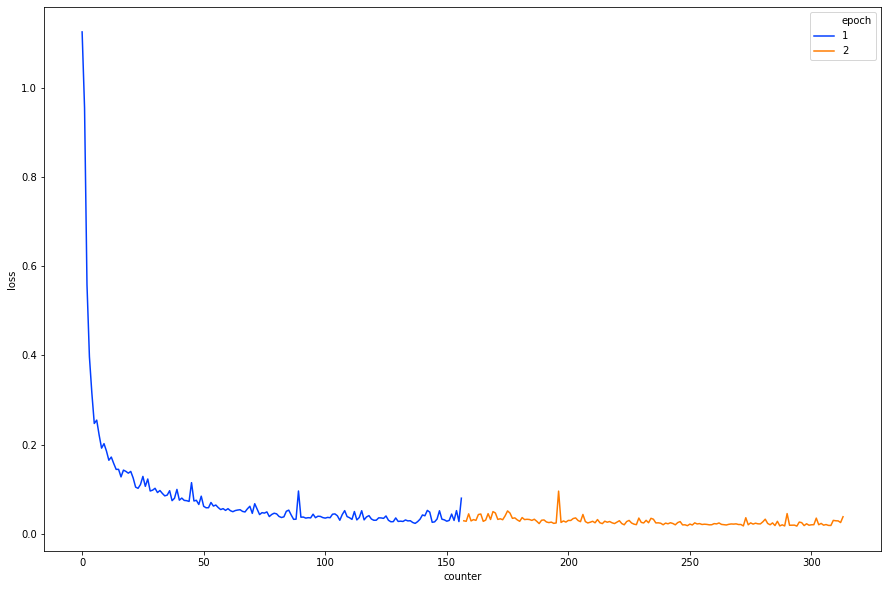

In [90]:
plt.figure(figsize=(15,10))
sns.lineplot(data=loss_df,x="counter",y="loss",hue="epoch",palette=sns.color_palette("bright",n_colors=len(loss_df.epoch.unique())))

In [91]:
imgs = ops[0][-1][1].reshape(-1,3,32,32).numpy()

In [92]:
imgs = imgs.transpose(0,2,3,1)

In [93]:
pred = ops[0][-1][2].reshape(-1,3,32,32).detach().numpy()

In [94]:
pred = pred.transpose(0,2,3,1)

In [98]:
index = 6

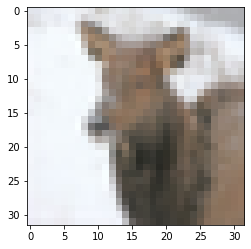

In [99]:
plt.imshow(imgs[index])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


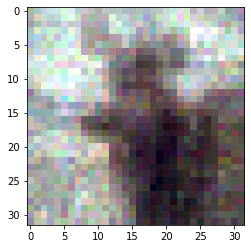

In [100]:
plt.imshow(pred[index])